# Arab-Andalusian Dataset
This notebook provides a general overview of the data, label distributions and datastructures used in the project 

In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from utilities.corpus_search import *
from utilities.model_matching_computation import *
from utilities.temporal_analysis import *
from utilities.features_eng import *
import os

import matplotlib.gridspec as gridspec
import numpy as np
num_tracks_xml = 0
for track_id in get_all_id_tracks():
        path = DF_PATH_TRACKS + track_id + '/' + track_id + '.xml'
        if os.path.exists(path):
                num_tracks_xml += 1
print(f"Number of tracks in the dataset: {len(get_all_id_tracks())} |----|  Number of digital scores available: {num_tracks_xml}")

Number of tracks in the dataset: 164 |----|  Number of digital scores available: 158


In [ ]:
from experiments.run_experiments import *
run_ModelBasedAI_experiment("nawba")

In [ ]:
with open("corpus-dataset/andalusian_description.json") as file:
    data = (json.load(file))


section_list = []
mbids = []
for entry in data:
    for section in entry.get('sections', []):
        mbids.append(entry.get('mbid'))
        section_list.append(section)

df_section = pd.DataFrame(section_list)

df_section['track_id'] = mbids
df_section['tab'] = df_section['tab'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df_section['nawba'] = df_section['nawba'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df_section['mizan'] = df_section['mizan'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
df_section['form'] = df_section['form'].apply(lambda x: (x)['id'] if pd.notnull(x) else None)
print(f"These are all sections available in the dataset \n {'-' * 300}")
df_section

These are all sections available in the dataset 
 ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------


847

In [3]:
df_notes = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')
df_notes = label_length(df_notes)
print(f"Mean length of section {df_notes['length_section'].mean()} sec/ {df_notes['length_section'].mean() / 60} min \
      {df_notes['length_section'].std()} sec/ {df_notes['length_section'].std() / 60}")
df_notes['tie'] = df_notes['tie'].fillna(-1)
df_notes = df_notes.dropna()
df_notes.info()

Mean length of section 965.5801993755782 sec/ 16.093003322926304 min       748.3583241281497 sec/ 12.472638735469161
<class 'pandas.core.frame.DataFrame'>
Index: 727605 entries, 0 to 768472
Data columns (total 16 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   NoteAndRest      727605 non-null  object 
 1   timestamp_(scs)  727605 non-null  float64
 2   measure_number   727605 non-null  int64  
 3   quarterLength    727605 non-null  object 
 4   bpm              727605 non-null  int64  
 5   beatStrength     727605 non-null  float64
 6   offset           727605 non-null  object 
 7   tie              727605 non-null  object 
 8   isChord          727605 non-null  bool   
 9   mizan            727605 non-null  float64
 10  form             727605 non-null  float64
 11  nawba            727605 non-null  float64
 12  tab              727605 non-null  float64
 13  section_id       727605 non-null  object 
 14  key              727

/tmp/ipykernel_302221/1929934186.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(f'graphs/{track}.pt')
/tmp/ipykernel_302221/1929934186.py:9: FutureWa

Loaded 158 graphs
Total note nodes: 5126
Edge types: [('note', 'onset', 'note'), ('note', 'consecutive', 'note'), ('note', 'during', 'note'), ('note', 'rest', 'note'), ('note', 'consecutive_rev', 'note'), ('note', 'during_rev', 'note'), ('note', 'rest_rev', 'note')]


/tmp/ipykernel_302221/1929934186.py:127: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


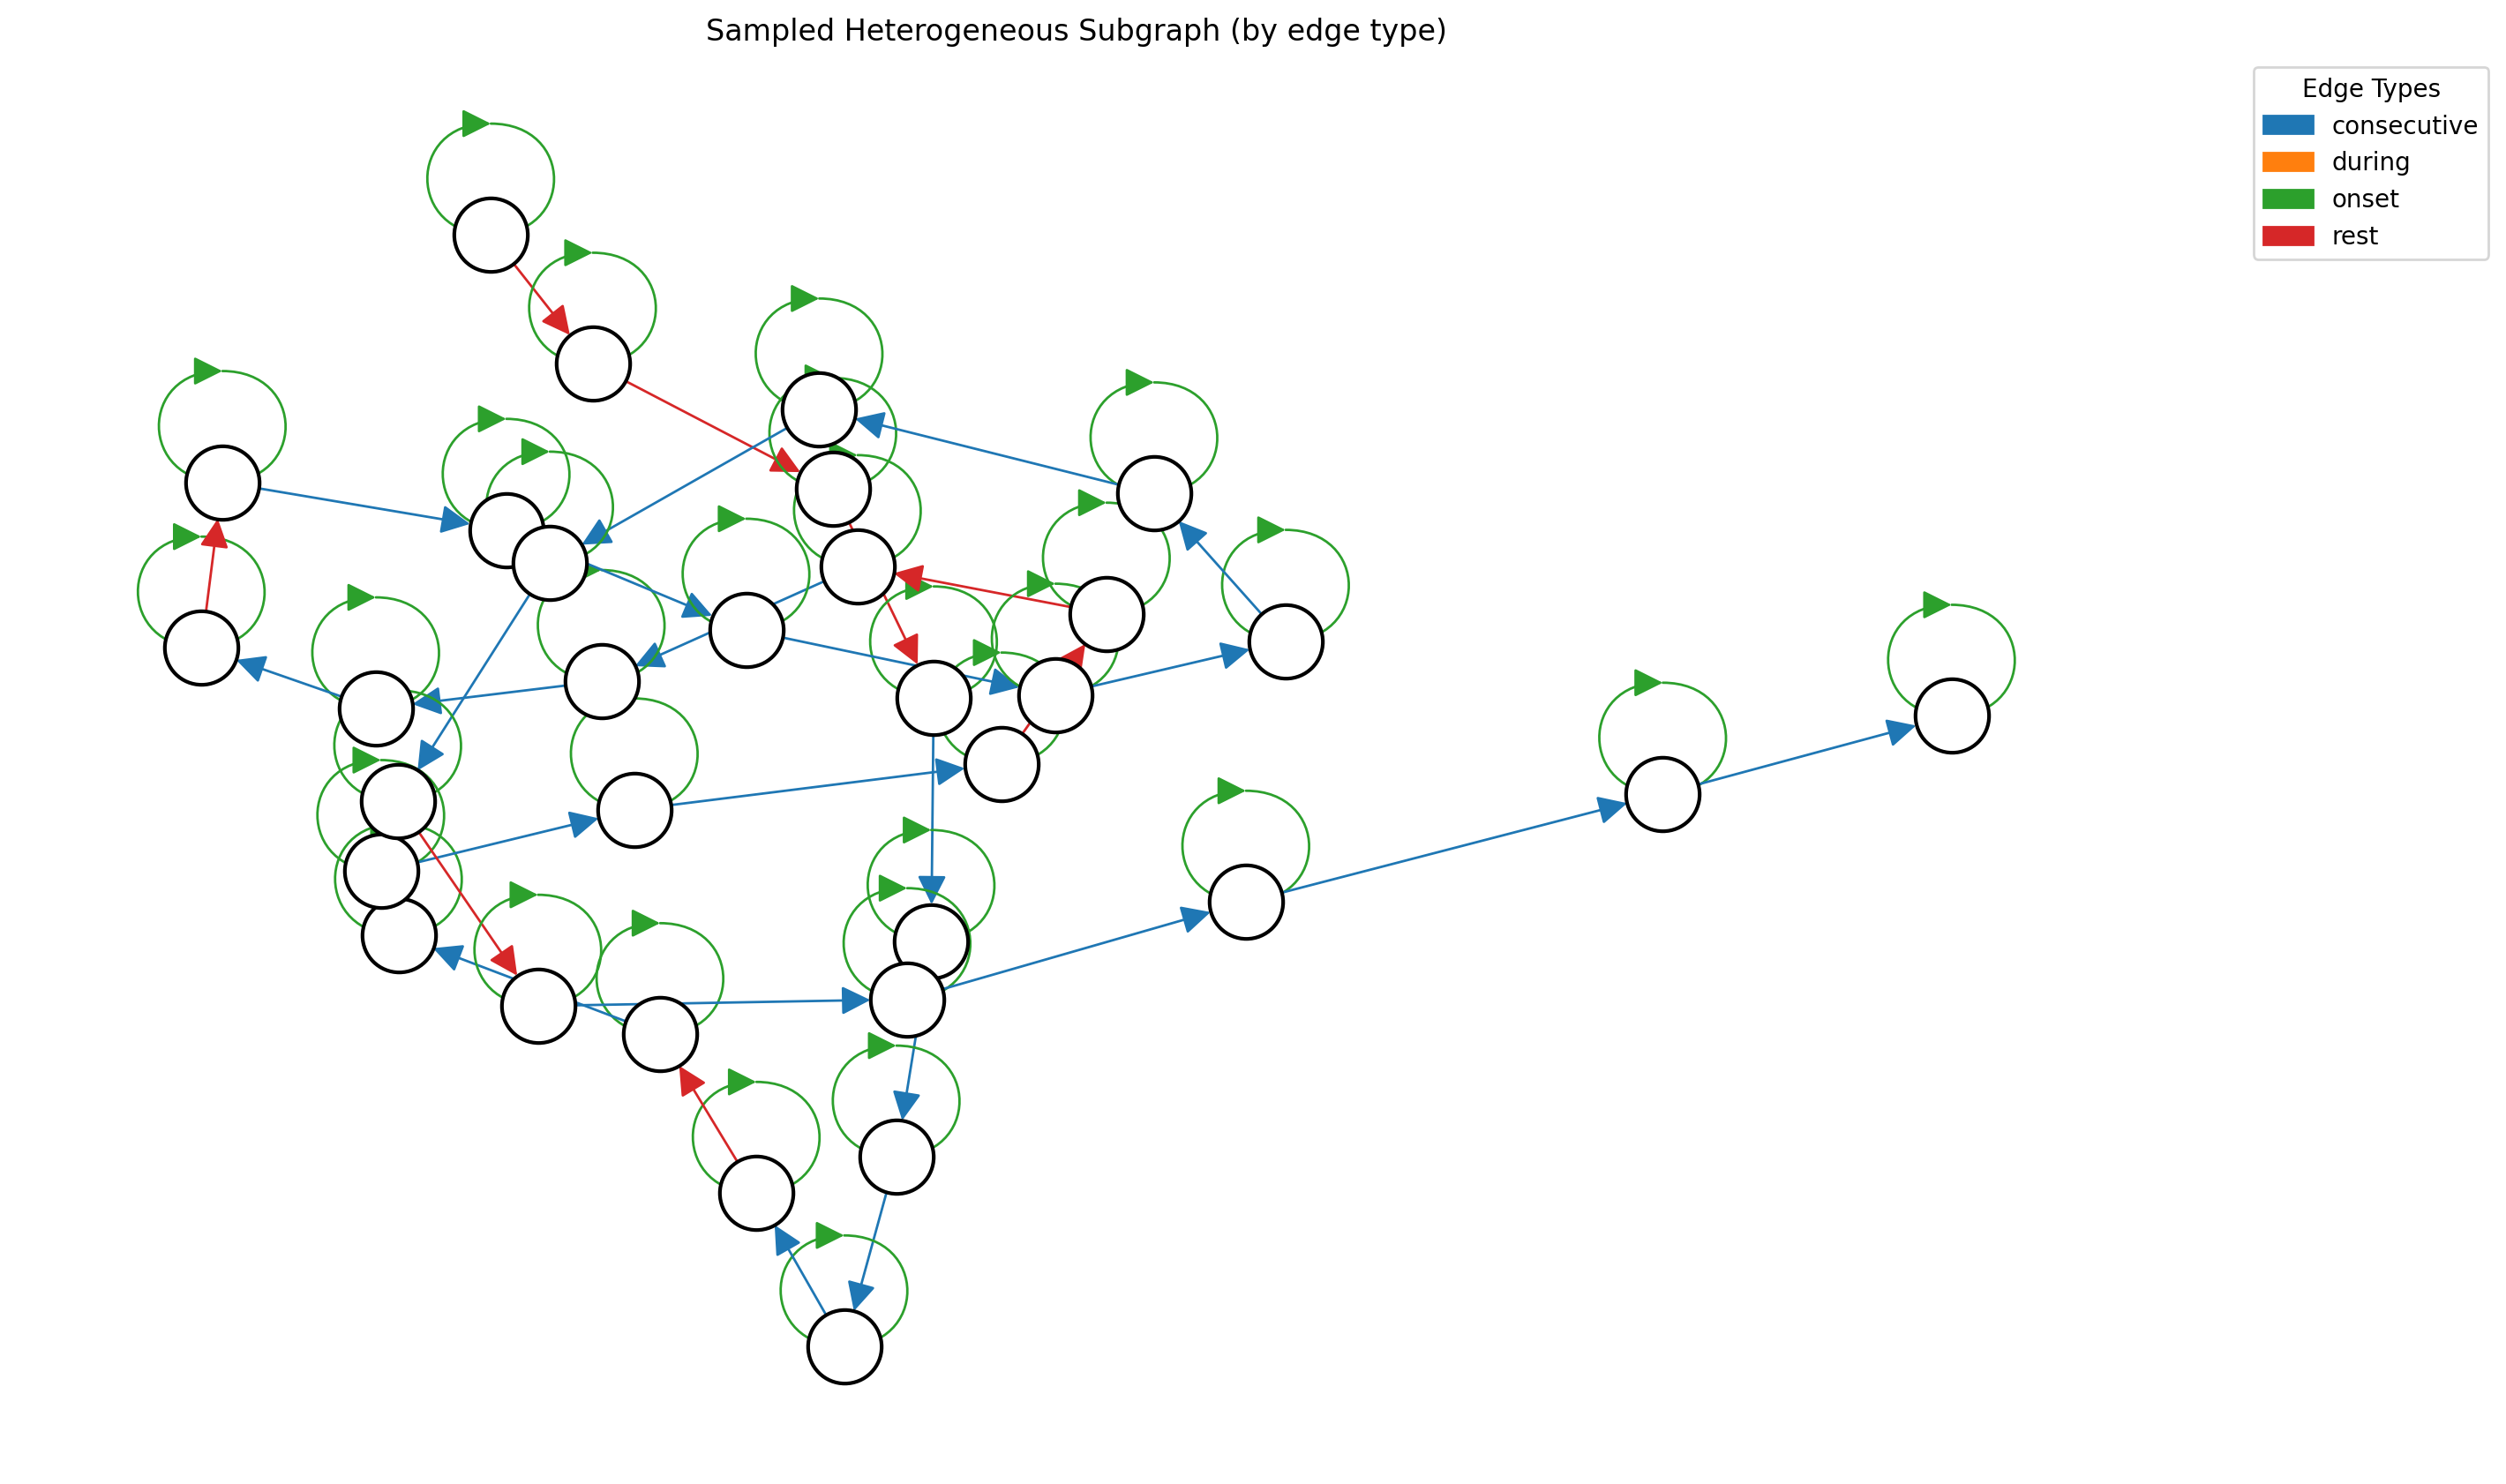

In [ ]:
import torch
graphs = []
graphs_y = []
label = "tab"
for track in get_all_id_tracks():
   
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if not os.path.exists(path): continue
    graph = torch.load(f'graphs/{track}.pt')
    
    #if not graph['note'][f'y_{label}'] in (LABEL_LIST_TRAIN[label]): continue
    #graphs_y.append(REPLACE_STRING[label][str(int(graph['note'][f'y_{label}']))])
    graphs.append(graph)

print(f"Loaded {len(graphs)} graphs",  flush=True)

import os
import torch
import random
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.loader import NeighborLoader
import matplotlib.patches as mpatches


# === Load Graph ===
track = "d5cc773e-9d31-42e8-b9de-91374fe7153b"  # Replace this
#track = "d66d44e9-f722-4b23-8753-0dea2818f475"  # Replace this
graph_path = f'graphs/{track}.pt'

if not os.path.exists(graph_path):
    raise FileNotFoundError(f"Missing file: {graph_path}")

graph_to_vis = torch.load(graph_path, weights_only=False)

print("Total note nodes:", graph_to_vis['note'].num_nodes)
print("Edge types:", graph_to_vis.edge_types)

# === Sampling Configuration ===
num_neighbors = {}
for edge_type in graph_to_vis.edge_types:
    
    if 'rest' in edge_type[1] or 'onset' in edge_type[1]:
        num_neighbors[edge_type] = [500]  # prioritize rest/onset
    elif 'consecutive' in edge_type[1]:
        num_neighbors[edge_type] = [1]    # minimal consecutive
    else:
        num_neighbors[edge_type] = [20]   # deprioritize other edges

loader = NeighborLoader(
    graph_to_vis,
    num_neighbors=num_neighbors,
    input_nodes=("note", torch.arange(2000)),  # seed with notes
    batch_size=32,
    shuffle=False
)

sampled_data = next(iter(loader))

# === Visualization Function ===
def visualize_hetero_sample(sampled_data, max_nodes=100):
    G = nx.DiGraph()
    node_colors = {}
    color_map_nodes = {}
    color_map_edges = {}
    edge_labels = {}

    # Assign unique color per node type
    for i, node_type in enumerate(sampled_data.node_types):
        
        color_map_nodes[node_type] = f"C{i}"

    # Filter forward edge types
    unique_edge_types = sorted({et[1] for et in sampled_data.edge_types if "rev" not in et[1]})
    

    # Assign color per edge type
    edge_colors_cycle = plt.cm.tab10.colors
    color_map_edges = {rel: edge_colors_cycle[i % len(edge_colors_cycle)] for i, rel in enumerate(unique_edge_types)}

    # Build graph
    for edge_type in sampled_data.edge_types:
        src_type, rel_type, dst_type = edge_type
        if "rev" in rel_type:
            continue

        
        edge_index = sampled_data[edge_type].edge_index
        for i in range(edge_index.size(1)):
            src_id = edge_index[0, i].item()
            dst_id = edge_index[1, i].item()
            #if src_id == dst_id:
             #  continue

            src = f"{src_type}_{src_id}"
            dst = f"{dst_type}_{dst_id}"
            G.add_edge(src, dst)
            edge_labels[(src, dst)] = rel_type
            node_colors[src] = color_map_nodes[src_type]
            node_colors[dst] = color_map_nodes[dst_type]

    # Prepare edge colors matching G.edges()
    edge_colors = []
    for edge in G.edges():
        rel = edge_labels.get(edge, None)
        edge_colors.append(color_map_edges.get(rel, "gray"))

    # Layout & Plot
    pos = nx.spring_layout(G, seed=42, k=0.5, iterations=100)

    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos,
        with_labels=False,
        node_color='white',
        edgecolors='black',
        linewidths=1.5,
        edge_color=edge_colors,
        node_size=900,
        arrowsize=25
    )

    # Add legend for edge types
    edge_patches = [mpatches.Patch(color=color_map_edges[rel], label=rel) for rel in unique_edge_types]
    plt.legend(handles=edge_patches, title="Edge Types", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("Sampled Heterogeneous Subgraph (by edge type)")
    plt.tight_layout()
    plt.show()


# === Run ===
visualize_hetero_sample(sampled_data)


In [6]:
import numpy as np
nawba_f1 = [81.3, 79.1, 78.0, 81.3, 79.8, 79.2, 81.6, 82.3, 79.0, 82.5, 81.7, 79.7, 
            86.1, 85.4, 83.0, 84.7, 86.2, 83.0, 85.2, 86.9, 85.2, 85.9, 85.8, 85.1,
            84.7, 84.7, 83.7, 84.4, 84.1, 83.2, 84.0, 85.8, 84.4, 85.0, 85.4, 85.3,
            82.0, 80.5, 79.4, 80.9, 81.7, 79.2, 81.9, 83.3, 80.4, 82.3, 82.3, 83.0,
            80.4, 80.7, 83.9, 79.2, 80.6, 83.8, 78.8, 82.2, 85.4, 79.7, 83.4, 85.2,
              86.5, 87.0]
tab_f1 = [82.0, 81.3, 77.2, 82.1, 79.3, 77.9, 81.7, 81.98, 77.9, 82.6, 82.2, 80.3, 85.3, 84.3, 80.8, 84.1, 84.4, 82.8, 84.7, 85.4, 84.9, 85.6, 84.2, 84.4, 85.6, 83.6, 84.5, 85.0, 83.7, 84.4, 84.7, 85.1, 84.7, 85.4, 85.3, 86.6, 84.0, 84.4, 80.4, 85.0, 85.0, 81.6, 84.9, 86.0, 82.4, 85.8, 87.0, 82.8, 84.4, 82.6, 83.2, 83.7, 83.8, 85.8, 83.9, 83.8, 85.5, 83.9, 84.7, 83.7, 89.7, 88.8]
nawba_f1 = np.array(nawba_f1)
tab_f1 = np.array(tab_f1)
print((nawba_f1 - tab_f1).mean())
print((nawba_f1 - tab_f1).std())

-0.9093548387096769
1.837788705401792


/tmp/ipykernel_1082/9586125.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


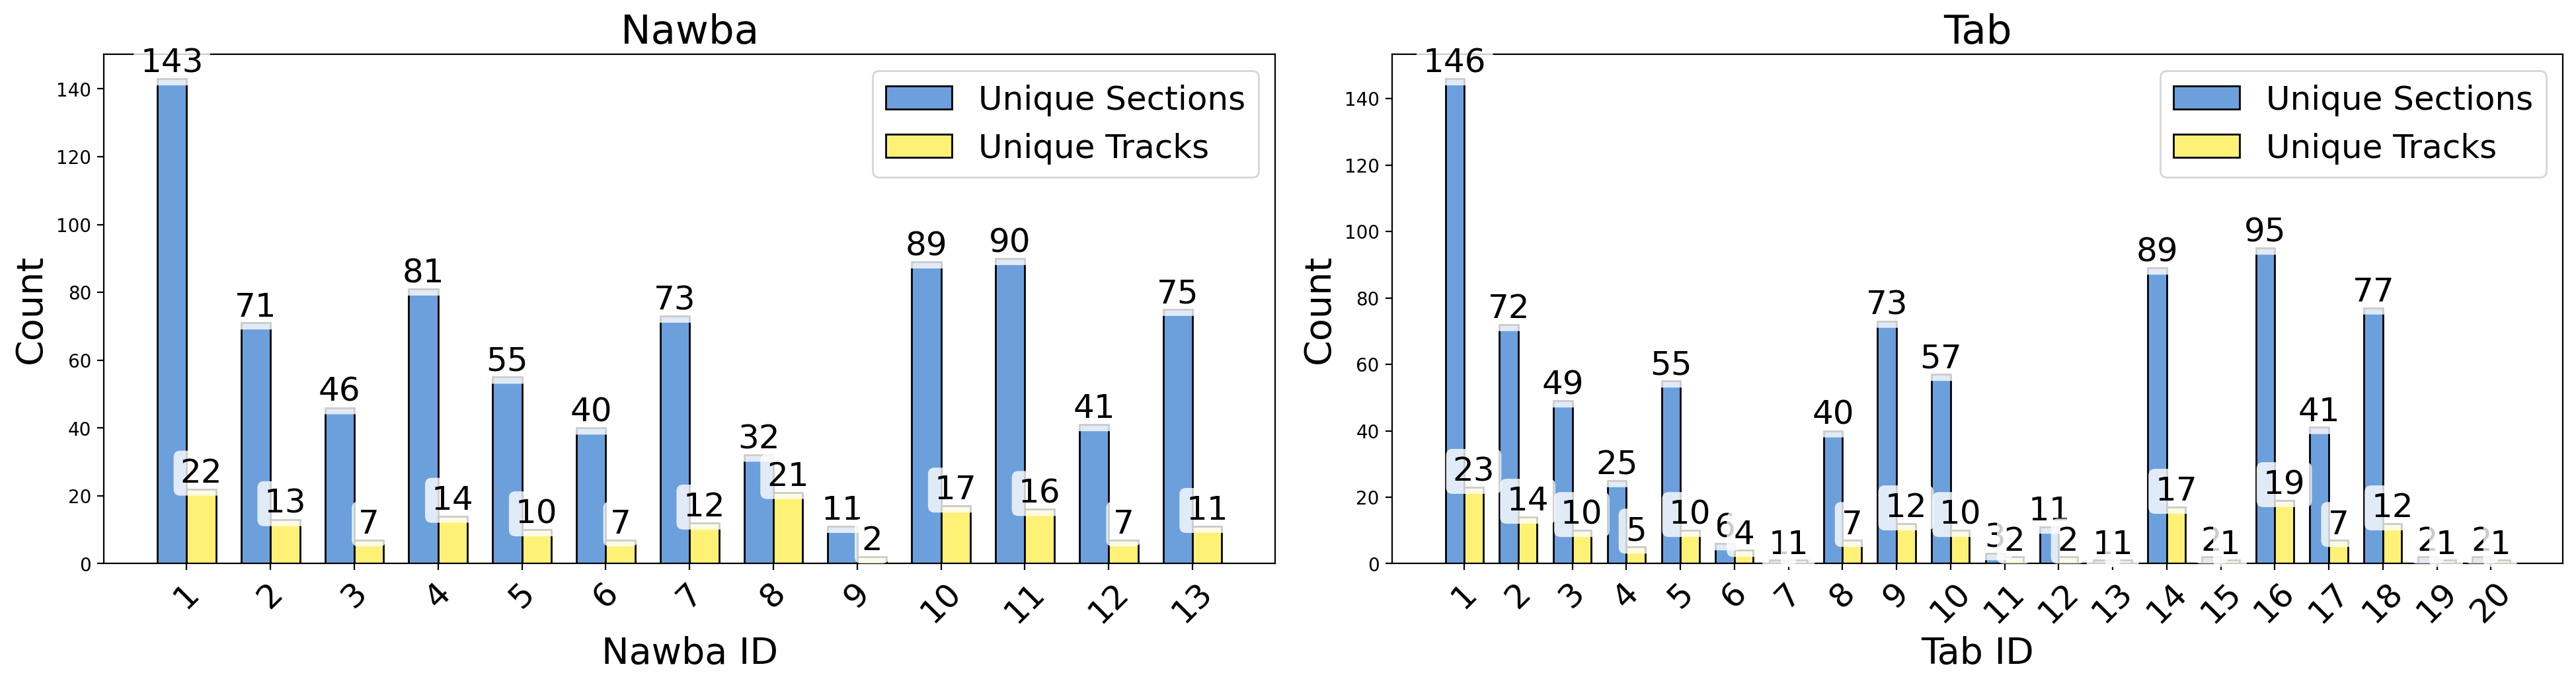

In [21]:
fig = plt.figure(figsize=(24, 5))  # Wider figure
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)  # Reduced spacing between plots

bar_width = 0.35

for i, l in enumerate(['nawba', 'tab']):
    labels = LABEL_LIST[l]
    x = np.arange(len(labels))  # One x position per label

    values1 = []
    values2 = []

    for label in labels:
        section_count = len(df_section[df_section[l] == label])
        track_count = df_section[df_section[l] == label]['track_id'].nunique()

        values1.append(section_count)
        values2.append(track_count)

    ax = fig.add_subplot(gs[0, i])

    bars1 = ax.bar(x - bar_width/2, values1, width=bar_width, color='#6ca0dc', edgecolor='black', label='Unique Sections')
    bars2 = ax.bar(x + bar_width/2, values2, width=bar_width, color='#fff176', edgecolor='black', label='Unique Tracks')


    ax.set_title(l.capitalize(), fontsize=22)
    ax.set_xlabel(f'{l.capitalize()} ID', fontsize=20)
    ax.set_ylabel('Count', fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels([str(label) for label in labels], rotation=45, fontsize=18)
    ax.legend(loc='upper right', fontsize=18)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center',
                va='bottom',
                fontsize=18,
                bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2', alpha=0.8)
            )

plt.tight_layout()
plt.show()



=== REST FREQUENCY COMPARISON ===
Full corpus: 13.09% rests (100,683 of 769,352 notes)
Excluded slice: 18.96% rests (7,916 of 41,747 notes)
Slice contains 7.86% of all rests

=== REST DURATION ANALYSIS ===
Full corpus rest durations:
count    100683.000000
mean          0.756867
std           1.051405
min           0.125000
25%           0.500000
50%           0.500000
75%           0.500000
max          12.000000
Name: quarterLength, dtype: float64

Excluded slice rest durations:
count    7916.000000
mean        2.321390
std         2.741055
min         0.250000
25%         0.500000
50%         0.500000
75%         3.000000
max        12.000000
Name: quarterLength, dtype: float64

=== MEASURE BOUNDARY ANALYSIS ===
Found 3756 rests at measure boundaries
Boundary rest durations:
count    3756.000000
mean        4.310437
std         2.872057
min         0.250000
25%         1.000000
50%         3.000000
75%         8.000000
max        12.000000
Name: quarterLength, dtype: float64

=== B

/tmp/ipykernel_108750/357700535.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice['strong_beat'] = slice['beatStrength'] > 0.7  # Adjust threshold as needed
/tmp/ipykernel_108750/357700535.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice['offset_rounded'] = slice['offset'].round(2)


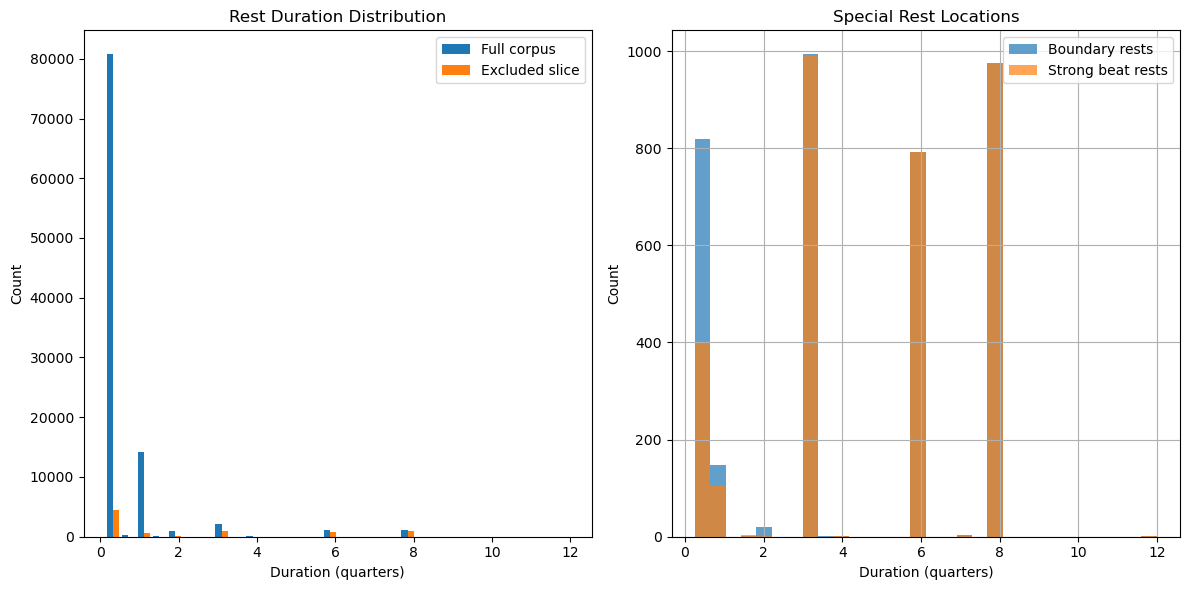


=== COMBINED INSIGHTS ===

Characteristics of long rests (>1.5 quarters):
- On measure boundaries: 99.72%
- On strong beats: 98.47%
- Both: 98.47%


/tmp/ipykernel_108750/357700535.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slice['long_rest'] = (slice['NoteAndRest'] == 'Rest') & (slice['quarterLength'] > 1.5)


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df_notes = pd.read_json('note_corpus3.json', orient='split', compression='infer')

# Preprocess columns (as you showed earlier)
df_notes['quarterLength'] = [0.33 if i == '1/3' else i for i in df_notes['quarterLength']]
df_notes['offset'] = [8/3 if i == '8/3' else i for i in df_notes['offset']]
df_notes['offset'] = [7/3 if i == '7/3' else i for i in df_notes['offset']]
df_notes['tie'] = df_notes['tie'].fillna(-1)

# Create the slice with missing mizan
slice = df_notes[df_notes['mizan'].isna()]

# Basic Rest Statistics Comparison
print("\n=== REST FREQUENCY COMPARISON ===")
total_notes = len(df_notes)
slice_notes = len(slice)
total_rests = len(df_notes[df_notes['NoteAndRest'] == 'Rest'])
slice_rests = len(slice[slice['NoteAndRest'] == 'Rest'])

print(f"Full corpus: {total_rests/total_notes:.2%} rests ({total_rests:,} of {total_notes:,} notes)")
print(f"Excluded slice: {slice_rests/slice_notes:.2%} rests ({slice_rests:,} of {slice_notes:,} notes)")
print(f"Slice contains {slice_rests/total_rests:.2%} of all rests")

# Duration Analysis
print("\n=== REST DURATION ANALYSIS ===")
print("Full corpus rest durations:")
print(df_notes[df_notes['NoteAndRest'] == 'Rest']['quarterLength'].describe())
print("\nExcluded slice rest durations:")
print(slice[slice['NoteAndRest'] == 'Rest']['quarterLength'].describe())

# Detect Measure Boundaries (using measure_number)
print("\n=== MEASURE BOUNDARY ANALYSIS ===")
# Create a shifted measure number column to detect boundaries
slice_sorted = slice.sort_values(['section_id', 'measure_number', 'offset'])
slice_sorted['next_measure'] = slice_sorted.groupby('section_id')['measure_number'].shift(-1)
slice_sorted['is_boundary'] = slice_sorted['next_measure'] != slice_sorted['measure_number']

# Analyze rests at boundaries
boundary_rests = slice_sorted[(slice_sorted['NoteAndRest'] == 'Rest') & 
                             (slice_sorted['is_boundary'])]
print(f"Found {len(boundary_rests)} rests at measure boundaries")
print("Boundary rest durations:")
print(boundary_rests['quarterLength'].describe())

# Beat Strength Analysis
print("\n=== BEAT STRENGTH ANALYSIS ===")
slice['strong_beat'] = slice['beatStrength'] > 0.7  # Adjust threshold as needed
strong_beat_rests = slice[(slice['NoteAndRest'] == 'Rest') & 
                         (slice['strong_beat'])]
print(f"Found {len(strong_beat_rests)} rests on strong beats")
print("Strong beat rest durations:")
print(strong_beat_rests['quarterLength'].describe())

# Offset Pattern Analysis
print("\n=== OFFSET PATTERN ANALYSIS ===")
slice['offset_rounded'] = slice['offset'].round(2)
rest_offset_patterns = slice[slice['NoteAndRest'] == 'Rest'].groupby('offset_rounded').size().sort_values(ascending=False)
print("Most common rest positions:")
print(rest_offset_patterns.head(10))

# Visualization
print("\n=== VISUALIZATION ===")
plt.figure(figsize=(12, 6))

# Duration distribution
plt.subplot(1, 2, 1)
plt.hist([df_notes[df_notes['NoteAndRest'] == 'Rest']['quarterLength'],
          slice[slice['NoteAndRest'] == 'Rest']['quarterLength']],
          bins=30, label=['Full corpus', 'Excluded slice'])
plt.title('Rest Duration Distribution')
plt.xlabel('Duration (quarters)')
plt.ylabel('Count')
plt.legend()

# Position analysis
plt.subplot(1, 2, 2)
boundary_rests['quarterLength'].hist(bins=30, alpha=0.7, label='Boundary rests')
strong_beat_rests['quarterLength'].hist(bins=30, alpha=0.7, label='Strong beat rests')
plt.title('Special Rest Locations')
plt.xlabel('Duration (quarters)')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

# Combined Insights
print("\n=== COMBINED INSIGHTS ===")
slice['long_rest'] = (slice['NoteAndRest'] == 'Rest') & (slice['quarterLength'] > 1.5)
special_rests = slice[slice['long_rest']].copy()
special_rests['boundary'] = special_rests['offset'].round(2).isin(rest_offset_patterns.head(5).index)
special_rests['strong_beat'] = special_rests['beatStrength'] > 0.7

print("\nCharacteristics of long rests (>1.5 quarters):")
print(f"- On measure boundaries: {special_rests['boundary'].mean():.2%}")
print(f"- On strong beats: {special_rests['strong_beat'].mean():.2%}")
print(f"- Both: {(special_rests['boundary'] & special_rests['strong_beat']).mean():.2%}")

In [20]:
df = (df_notes.groupby("section_id")['NoteAndRest'].count())
print(f"Average amount of notes in a track: {int(df.mean())} ± {int(df.std())}")
print(df.max())

print(df.sort_values(ascending=False)[1])

Average amount of notes in a track: 924 ± 1075
7304
7218


/tmp/ipykernel_65704/874335140.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(df.sort_values(ascending=False)[1])


In [35]:
for nawba in df_section["nawba"].unique():
    if nawba == 4:
        print(f"For nawba {nawba}, there exist tab:",df_section[df_section["nawba"] == nawba]["tab"].unique())

For nawba 4, there exist tab: [ 4 10]


In [51]:
test = df_notes[df_notes["nawba"] == 4]
#>for nawba in df_notes["nawba"].unique():
    #if nawba == 4:
        #print(f"For nawba {nawba}, there exist tab:",df_notes[df_notes["nawba"] == nawba]["tab"].unique())
test[test["tab"] ==4]["section_id"].unique()

array(['64eb6302-34ec-4434-a004-4e7e503c3e6c0',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83790',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83791',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83792',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83793',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83794',
       'c8029ba7-5827-4628-b0bd-1adcc1bb83795',
       '7e3ee6f2-c42f-4da4-9816-45aadcffea880',
       '7e3ee6f2-c42f-4da4-9816-45aadcffea881',
       '7e3ee6f2-c42f-4da4-9816-45aadcffea882',
       '7e3ee6f2-c42f-4da4-9816-45aadcffea883',
       'b018d0fd-9955-47bb-9ef2-d291f500eebe0',
       'b018d0fd-9955-47bb-9ef2-d291f500eebe1',
       'b018d0fd-9955-47bb-9ef2-d291f500eebe2',
       'b018d0fd-9955-47bb-9ef2-d291f500eebe3',
       'b018d0fd-9955-47bb-9ef2-d291f500eebe4',
       '860a5ee6-6f83-42b1-a277-8ebad8d15b370',
       '860a5ee6-6f83-42b1-a277-8ebad8d15b371',
       '860a5ee6-6f83-42b1-a277-8ebad8d15b372',
       '860a5ee6-6f83-42b1-a277-8ebad8d15b373',
       '860a5ee6-6f83-42b1-a277-8ebad8d1

In [ ]:
For nawba 11.0, there exist tab: [16.]
For nawba 8.0, there exist tab: [ 6. 19. 16. 20. 15. 18.  7.  2. 11. 10.  3.  1. 13.]
For nawba 7.0, there exist tab: [9.]
For nawba 4.0, there exist tab: [ 4. 10.]
For nawba 13.0, there exist tab: [18.]
For nawba 12.0, there exist tab: [17.]
For nawba 3.0, there exist tab: [3.]
For nawba 5.0, there exist tab: [5.]
For nawba 2.0, there exist tab: [2.]
For nawba 1.0, there exist tab: [1.]
For nawba 10.0, there exist tab: [14.]
For nawba 6.0, there exist tab: [8.]
For nawba 9.0, there exist tab: [12.]

section_id
01da143e-4224-4692-8e6c-1d55f6de8a6d0     287
01da143e-4224-4692-8e6c-1d55f6de8a6d1     242
01da143e-4224-4692-8e6c-1d55f6de8a6d2    2748
01da143e-4224-4692-8e6c-1d55f6de8a6d3     663
01da143e-4224-4692-8e6c-1d55f6de8a6d4     985
                                         ... 
fb387964-4764-4900-91b5-f2ea7e10b7860     488
fb387964-4764-4900-91b5-f2ea7e10b7861    2579
fb387964-4764-4900-91b5-f2ea7e10b7862     225
fb387964-4764-4900-91b5-f2ea7e10b7863     652
fb387964-4764-4900-91b5-f2ea7e10b7864     386
Name: NoteAndRest, Length: 787, dtype: int64

In [58]:
print(f"For training {'-' * 20}")
for l in ['nawba', 'tab', 'mizan']:
    for s in LABEL_LIST[l]:
        total_seconds = df_notes[df_notes[l] == s].groupby('section_id')['timestamp_(scs)'].max().sum()
        total_minutes = total_seconds // 60
        total_hours = total_seconds // 3600

        print(f"{l} {s}: Total duration: {total_minutes} minutes ({total_hours} hours)")

    #print(f"{l} : {len(df_windowed[df_windowed[l].isin(LABEL_LIST_TRAIN[l])]['section_id'].unique())} equally spaced ")
    #print(f"{l} : {len(df_notes[df_notes[l].isin(LABEL_LIST_TRAIN[l])]['section_id'].unique())} sections")
    #print(f"{l} : {len(df_section[df_section[l].isin(LABEL_LIST_TRAIN[l])]['track_id'].unique())} tracks")
    

For training --------------------
nawba 1: Total duration: 3422.0 minutes (57.0 hours)
nawba 2: Total duration: 1851.0 minutes (30.0 hours)
nawba 3: Total duration: 712.0 minutes (11.0 hours)
nawba 4: Total duration: 1298.0 minutes (21.0 hours)
nawba 5: Total duration: 1000.0 minutes (16.0 hours)
nawba 6: Total duration: 792.0 minutes (13.0 hours)
nawba 7: Total duration: 1799.0 minutes (29.0 hours)
nawba 8: Total duration: 246.0 minutes (4.0 hours)
nawba 9: Total duration: 351.0 minutes (5.0 hours)
nawba 10: Total duration: 2379.0 minutes (39.0 hours)
nawba 11: Total duration: 2097.0 minutes (34.0 hours)
nawba 12: Total duration: 583.0 minutes (9.0 hours)
nawba 13: Total duration: 1380.0 minutes (23.0 hours)
tab 1: Total duration: 3434.0 minutes (57.0 hours)
tab 2: Total duration: 1861.0 minutes (31.0 hours)
tab 3: Total duration: 731.0 minutes (12.0 hours)
tab 4: Total duration: 530.0 minutes (8.0 hours)
tab 5: Total duration: 1000.0 minutes (16.0 hours)
tab 6: Total duration: 50.0 m

In [16]:
print(f"Out of {df_notes['section_id'].str[:PREFIX_LENGTH].nunique()} tracks \n {20*'-'}")
for label in ["tab", "nawba"]:

    print(label, (df_notes[df_notes[label].isin(LABEL_LIST_TRAIN[label])]['section_id'].str[:PREFIX_LENGTH].nunique()))


Out of 158 tracks 
 --------------------
tab 127
nawba 136


In [ ]:
for label in ["tab", "nawba"]:
    for overlap in [0, 0.1, 0.3, 0.5]:
        for sequence_length in [256, 512, 1024]:
            print(label, overlap, sequence_length)
            df, pitch_distr_sections, ql_distr_sections = prepare_dataframe(label, overlap, sequence_length)
            print((df['section_id'].nunique()))
            

In [22]:
from graphmuse.loader import MuseNeighborLoader
from utilities.constants import *
from utilities.temporal_analysis import *
import matplotlib.pyplot as plt
from utilities.model_matching_computation import *
from utilities.features_eng import *
import pandas as pd
from music21 import *
from utilities.corpus_search import *
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
import warnings
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import torch
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.utils as rnn_utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from sklearn.utils.class_weight import compute_class_weight
from utilities.dl_utilities import *
from graphmuse.loader import MuseNeighborLoader
import torch
from torch.utils.data import DataLoader, TensorDataset
for subgraph_size in [128, 256]:

    random_state= 42
    batch_size= 16
    graphs = list()
    graphs_y = list()
    for track in get_all_id_tracks():
        
        path = DF_PATH_TRACKS + track + '/' + track + '.xml'
        if not os.path.exists(path): continue
        graph = torch.load(f'graphs/{track}.pt')

        if not graph['note'][f'y_{label}'] in (LABEL_LIST_TRAIN[label]): continue
        graphs_y.append(REPLACE_STRING[label][str(int(graph['note'][f'y_{label}']))])
        graphs.append(graph)


    class GraphDataset(Dataset):
        def __init__(self, graphs, labels):
            self.graphs = graphs
            self.labels = labels

        def __len__(self):
            return len(self.graphs)

        def __getitem__(self, idx):
            data = self.graphs[idx]
            data.y = self.labels[idx] 
            return data

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = GraphDataset(graphs, graphs_y)


    loader = MuseNeighborLoader(train_dataset, subgraph_size=subgraph_size, batch_size=batch_size,
                                    num_neighbors=[int(subgraph_size * 0.6), int(subgraph_size * 0.3), int(subgraph_size * 0.1)])

    total = 0
    for batch in loader:
        total += batch.batch_size if hasattr(batch, 'batch_size') else len(batch)
    print(f"Total samples in loader: {total}")


/tmp/ipykernel_274472/1973796665.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph = torch.load(f'graphs/{track}.pt')


Total samples in loader: 9972
Total samples in loader: 6996


In [15]:
from utilities.constants import *
from utilities.temporal_analysis import *
import matplotlib.pyplot as plt
from utilities.model_matching_computation import *
from utilities.features_eng import *
import pandas as pd
from music21 import *
from utilities.corpus_search import *
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from collections import defaultdict
from sklearn.model_selection import StratifiedKFold
import warnings
import random
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
import torch
from torch.optim.lr_scheduler import StepLR
import torch
import torch.nn as nn
import torch.nn.utils as rnn_utils
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils.class_weight import compute_class_weight
from utilities.dl_utilities import *
from graphmuse.loader import MuseNeighborLoader
warnings.filterwarnings("ignore")
from sklearn import svm
random_state= 42
batch_size= 16
graphs = list()
graphs_y = list()
label = "tab"
subgraph_size= 256
for track in get_all_id_tracks():
    
    path = DF_PATH_TRACKS + track + '/' + track + '.xml'
    if not os.path.exists(path): continue
    graph = torch.load(f'graphs/{track}.pt')

    if not graph['note'][f'y_{label}'] in (LABEL_LIST_TRAIN[label]): continue
    graphs_y.append(REPLACE_STRING[label][str(int(graph['note'][f'y_{label}']))])
    graphs.append(graph)


class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        data = self.graphs[idx]
        data.y = self.labels[idx] 
        return data

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_dataset = GraphDataset(graphs, graphs_y)


loader = MuseNeighborLoader(train_dataset, subgraph_size=subgraph_size, batch_size=batch_size,
                                num_neighbors=[int(subgraph_size * 0.6), int(subgraph_size * 0.3), int(subgraph_size * 0.1)])

total = 0
for batch in loader:

    total += batch.batch_size if hasattr(batch, 'batch_size') else len(batch)
print(f"Total samples in loader: {total}")


Total samples in loader: 6188


In [21]:
for batch in loader:
    for i in range(len(batch)):
        print((batch[i]["note"].x))
    

tensor([[1.6650e+03, 5.0000e-01, 1.6650e+03,  ..., 6.7000e+01, 1.0000e+00,
         0.0000e+00],
        [1.6655e+03, 5.0000e-01, 1.6655e+03,  ..., 6.5000e+01, 1.0000e+00,
         0.0000e+00],
        [1.6660e+03, 5.0000e-01, 1.6660e+03,  ..., 6.4000e+01, 1.0000e+00,
         0.0000e+00],
        ...,
        [1.8230e+03, 5.0000e-01, 1.8230e+03,  ..., 6.4000e+01, 1.0000e+00,
         0.0000e+00],
        [1.6635e+03, 5.0000e-01, 1.6635e+03,  ..., 6.7000e+01, 1.0000e+00,
         0.0000e+00],
        [1.8235e+03, 5.0000e-01, 1.8235e+03,  ..., 6.4000e+01, 1.0000e+00,
         0.0000e+00]])
tensor([[2.9215e+03, 2.5000e-01, 2.9215e+03,  ..., 6.0000e+01, 1.0000e+00,
         0.0000e+00],
        [2.9218e+03, 2.5000e-01, 2.9218e+03,  ..., 6.0000e+01, 1.0000e+00,
         0.0000e+00],
        [2.9220e+03, 5.0000e-01, 2.9220e+03,  ..., 6.5000e+01, 1.0000e+00,
         0.0000e+00],
        ...,
        [3.1060e+03, 1.0000e+00, 3.1060e+03,  ..., 6.7000e+01, 1.0000e+00,
         1.0000e+00],
   

KeyboardInterrupt: 